# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

Cloning into 'deep-learning-polytech-tp6-7'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 22 (delta 3), reused 7 (delta 1), pack-reused 8
Unpacking objects: 100% (22/22), done.


In [ ]:
cd deep-learning-polytech-tp6-7

/content/deep-learning-polytech-tp6-7


In [ ]:
!pip install torchsummary

In [ ]:
import argparse
import os
import time
import torch.optim.lr_scheduler
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            #torch.nn.Dropout(0.5),
            nn.Linear(1000, 10)
            
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        #print(output.shape)
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
           # transforms.GaussianBlur(kernel_size=27),
            #transforms.RandomRotation(degrees=180)
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
            transforms.CenterCrop(28)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, ep,optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        #print("epoch: ",ep)
        if True: 
          if i % PRINT_INTERVAL == 0:
              print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                    'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                    'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                    "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                    top1=avg_top1_acc, top5=avg_top5_acc))
              if optimizer:
                  loss_plot.plot()

    # Print summary
    if True: 
      print('\n===============> Total time {batch_time:d}s\t'
            'Avg loss {loss.avg:.4f}\t'
            'Avg Prec@1 {top1.avg:5.2f} %\t'
            'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
            batch_time=int(avg_batch_time.sum), loss=avg_loss,
            top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=100, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion,i, optimizer, cuda,)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion,i, cuda=cuda)
        # plot
        
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
        lr_sched.step()


In [ ]:
from torchsummary import summary
model = ConvNet()
#summary(model,(3,32,32))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.742s (0.742s)	Loss 2.3045 (2.3045)	Prec@1  12.5 ( 12.5)	Prec@5  53.1 ( 53.1)


<Figure size 432x288 with 0 Axes>

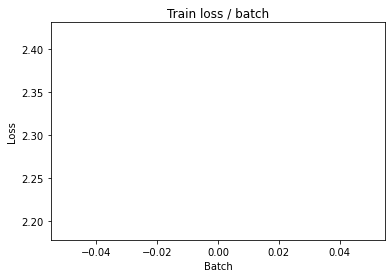

[TRAIN Batch 200/391]	Time 0.061s (0.056s)	Loss 1.5692 (1.7470)	Prec@1  43.0 ( 35.7)	Prec@5  90.6 ( 85.5)


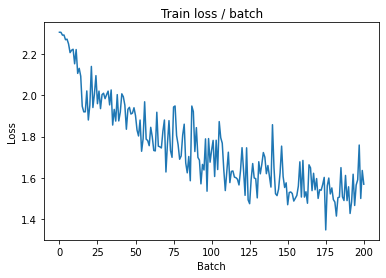


===============> Total time 21s	Avg loss 1.5964	Avg Prec@1 41.69 %	Avg Prec@5 88.95 %

[EVAL Batch 000/079]	Time 0.195s (0.195s)	Loss 1.2704 (1.2704)	Prec@1  59.4 ( 59.4)	Prec@5  91.4 ( 91.4)

===============> Total time 3s	Avg loss 1.2865	Avg Prec@1 53.52 %	Avg Prec@5 94.52 %



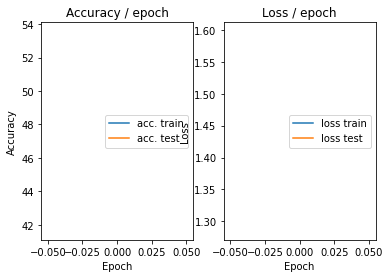

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.202s (0.202s)	Loss 1.2536 (1.2536)	Prec@1  54.7 ( 54.7)	Prec@5  96.1 ( 96.1)


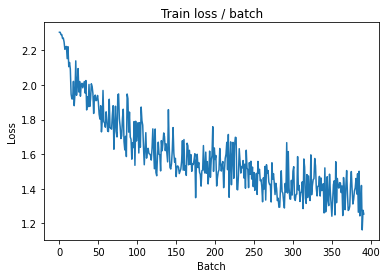

[TRAIN Batch 200/391]	Time 0.021s (0.053s)	Loss 1.3365 (1.2767)	Prec@1  54.7 ( 54.2)	Prec@5  93.8 ( 94.6)


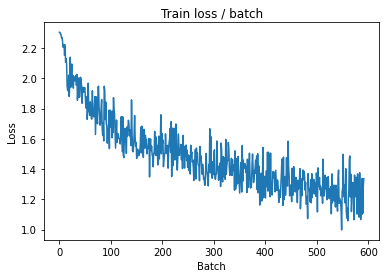


===============> Total time 20s	Avg loss 1.2385	Avg Prec@1 55.85 %	Avg Prec@5 94.75 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 1.1186 (1.1186)	Prec@1  61.7 ( 61.7)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.1529	Avg Prec@1 59.29 %	Avg Prec@5 95.62 %



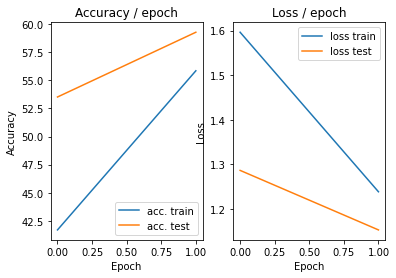

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.206s (0.206s)	Loss 1.2090 (1.2090)	Prec@1  57.0 ( 57.0)	Prec@5  93.8 ( 93.8)


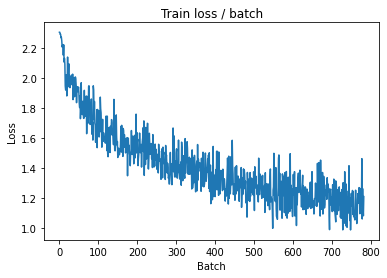

[TRAIN Batch 200/391]	Time 0.019s (0.055s)	Loss 1.0119 (1.1037)	Prec@1  68.0 ( 61.2)	Prec@5  98.4 ( 96.1)


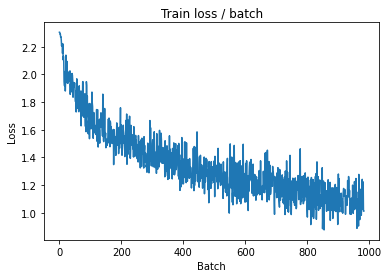


===============> Total time 21s	Avg loss 1.0785	Avg Prec@1 62.03 %	Avg Prec@5 96.25 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 0.9769 (0.9769)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 1.0045	Avg Prec@1 65.15 %	Avg Prec@5 96.73 %



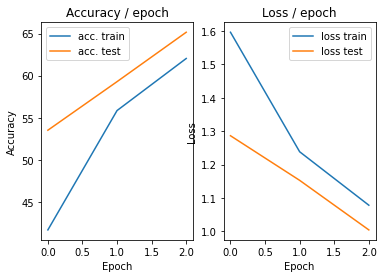

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 0.9528 (0.9528)	Prec@1  68.8 ( 68.8)	Prec@5  97.7 ( 97.7)


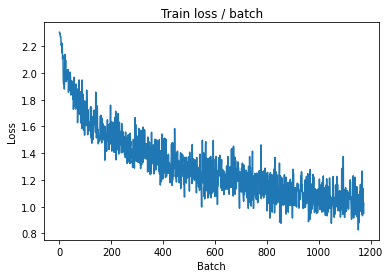

[TRAIN Batch 200/391]	Time 0.020s (0.055s)	Loss 1.0836 (0.9953)	Prec@1  63.3 ( 64.9)	Prec@5  95.3 ( 96.9)


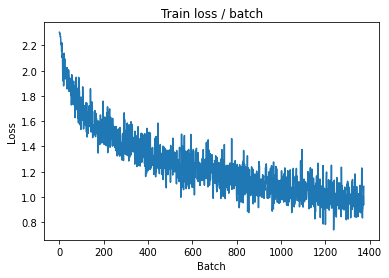


===============> Total time 21s	Avg loss 0.9810	Avg Prec@1 65.35 %	Avg Prec@5 96.98 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 0.8611 (0.8611)	Prec@1  74.2 ( 74.2)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 0.9022	Avg Prec@1 68.30 %	Avg Prec@5 97.43 %



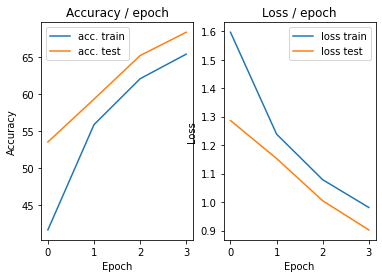

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.213s (0.213s)	Loss 0.9824 (0.9824)	Prec@1  65.6 ( 65.6)	Prec@5  97.7 ( 97.7)


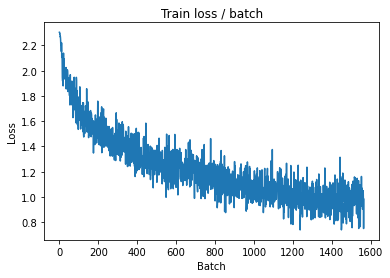

[TRAIN Batch 200/391]	Time 0.052s (0.054s)	Loss 0.8441 (0.9062)	Prec@1  75.0 ( 67.9)	Prec@5  96.9 ( 97.5)


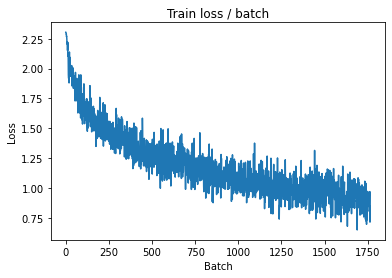


===============> Total time 21s	Avg loss 0.9042	Avg Prec@1 68.20 %	Avg Prec@5 97.42 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 0.8662 (0.8662)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 3s	Avg loss 0.8982	Avg Prec@1 68.64 %	Avg Prec@5 97.45 %



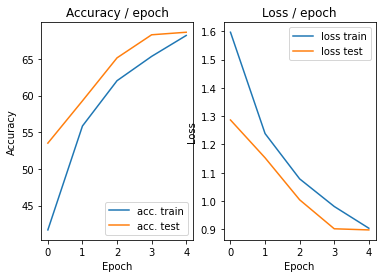

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 0.9264 (0.9264)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)


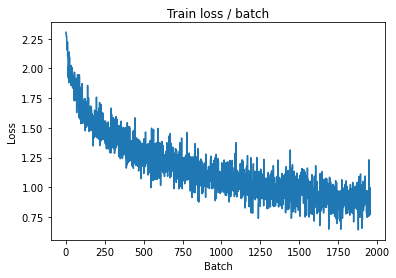

[TRAIN Batch 200/391]	Time 0.063s (0.055s)	Loss 0.7613 (0.8537)	Prec@1  72.7 ( 70.1)	Prec@5  99.2 ( 97.6)


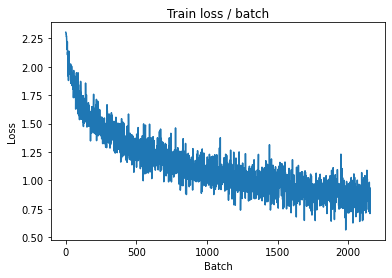


===============> Total time 21s	Avg loss 0.8482	Avg Prec@1 70.27 %	Avg Prec@5 97.70 %

[EVAL Batch 000/079]	Time 0.172s (0.172s)	Loss 0.7392 (0.7392)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 0.8167	Avg Prec@1 71.59 %	Avg Prec@5 97.80 %



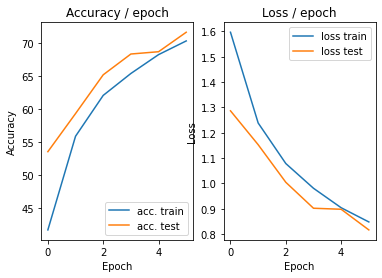

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.216s (0.216s)	Loss 0.7293 (0.7293)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)


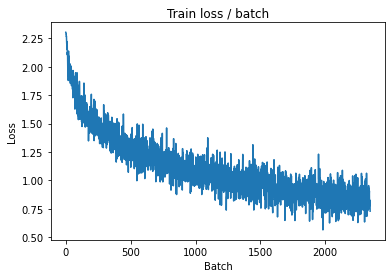

[TRAIN Batch 200/391]	Time 0.053s (0.055s)	Loss 0.9218 (0.7984)	Prec@1  68.8 ( 72.2)	Prec@5  94.5 ( 97.8)


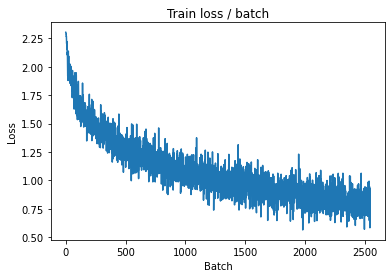


===============> Total time 21s	Avg loss 0.7961	Avg Prec@1 72.15 %	Avg Prec@5 97.97 %

[EVAL Batch 000/079]	Time 0.180s (0.180s)	Loss 0.7864 (0.7864)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 0.7949	Avg Prec@1 72.38 %	Avg Prec@5 98.04 %



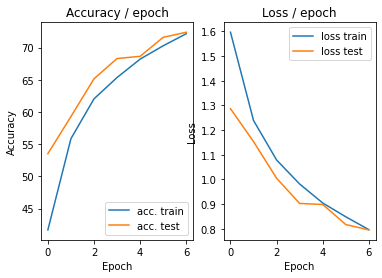

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.226s (0.226s)	Loss 0.7024 (0.7024)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)


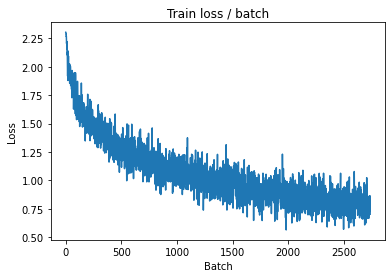

[TRAIN Batch 200/391]	Time 0.059s (0.055s)	Loss 0.7362 (0.7490)	Prec@1  76.6 ( 73.8)	Prec@5  98.4 ( 98.3)


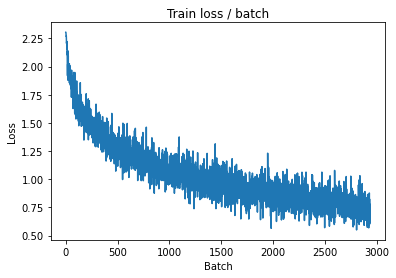


===============> Total time 21s	Avg loss 0.7553	Avg Prec@1 73.63 %	Avg Prec@5 98.15 %

[EVAL Batch 000/079]	Time 0.184s (0.184s)	Loss 0.6933 (0.6933)	Prec@1  75.0 ( 75.0)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.7486	Avg Prec@1 73.85 %	Avg Prec@5 98.38 %



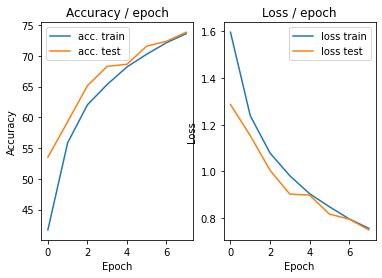

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.239s (0.239s)	Loss 0.7538 (0.7538)	Prec@1  75.0 ( 75.0)	Prec@5  97.7 ( 97.7)


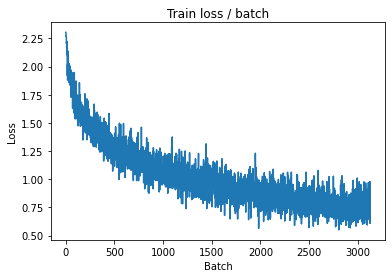

[TRAIN Batch 200/391]	Time 0.102s (0.056s)	Loss 0.6464 (0.7287)	Prec@1  82.0 ( 74.5)	Prec@5  97.7 ( 98.2)


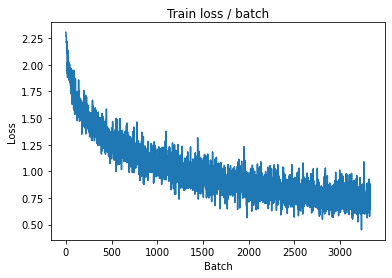


===============> Total time 21s	Avg loss 0.7206	Avg Prec@1 74.79 %	Avg Prec@5 98.32 %

[EVAL Batch 000/079]	Time 0.210s (0.210s)	Loss 0.7094 (0.7094)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.7590	Avg Prec@1 73.34 %	Avg Prec@5 98.24 %



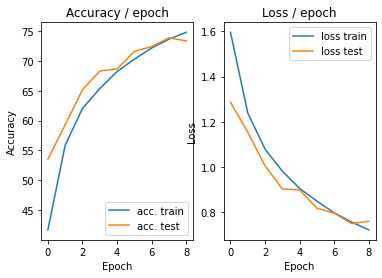

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 0.6573 (0.6573)	Prec@1  77.3 ( 77.3)	Prec@5  99.2 ( 99.2)


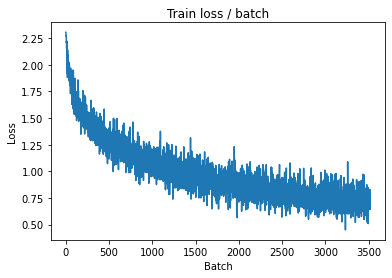

[TRAIN Batch 200/391]	Time 0.024s (0.055s)	Loss 0.7562 (0.6869)	Prec@1  74.2 ( 75.7)	Prec@5  95.3 ( 98.5)


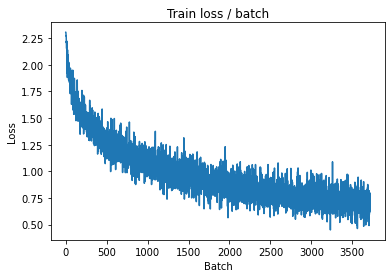


===============> Total time 21s	Avg loss 0.6814	Avg Prec@1 75.91 %	Avg Prec@5 98.51 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 0.7076 (0.7076)	Prec@1  77.3 ( 77.3)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.7230	Avg Prec@1 74.16 %	Avg Prec@5 98.50 %



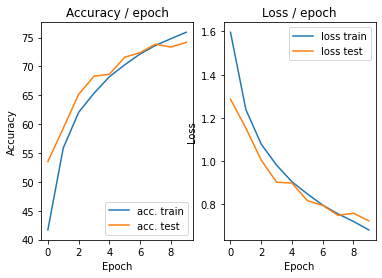

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.223s (0.223s)	Loss 0.7910 (0.7910)	Prec@1  68.0 ( 68.0)	Prec@5  99.2 ( 99.2)


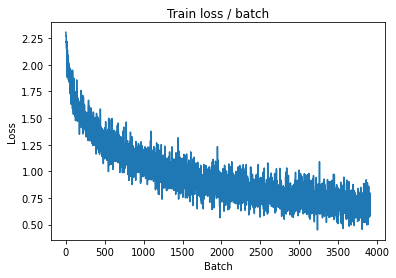

[TRAIN Batch 200/391]	Time 0.019s (0.056s)	Loss 0.6138 (0.6634)	Prec@1  76.6 ( 76.7)	Prec@5  99.2 ( 98.7)


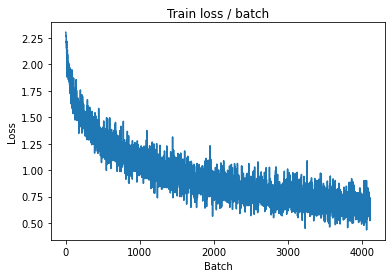


===============> Total time 21s	Avg loss 0.6595	Avg Prec@1 76.89 %	Avg Prec@5 98.71 %

[EVAL Batch 000/079]	Time 0.196s (0.196s)	Loss 0.6543 (0.6543)	Prec@1  76.6 ( 76.6)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.7032	Avg Prec@1 75.42 %	Avg Prec@5 98.46 %



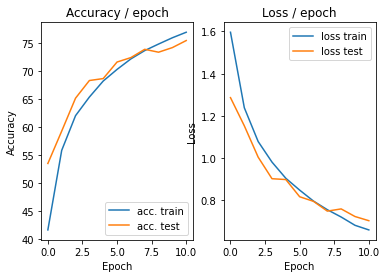

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.244s (0.244s)	Loss 0.7170 (0.7170)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)


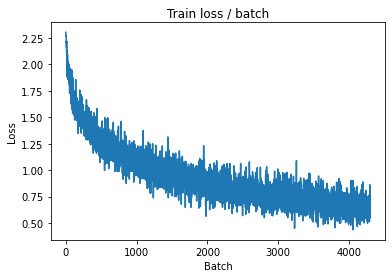

[TRAIN Batch 200/391]	Time 0.020s (0.055s)	Loss 0.5205 (0.6346)	Prec@1  77.3 ( 77.8)	Prec@5 100.0 ( 98.9)


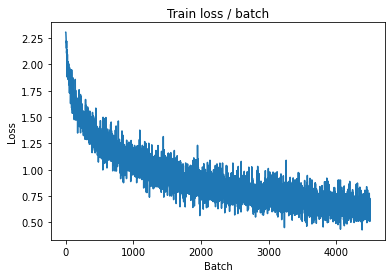


===============> Total time 21s	Avg loss 0.6363	Avg Prec@1 77.70 %	Avg Prec@5 98.80 %

[EVAL Batch 000/079]	Time 0.187s (0.187s)	Loss 0.6523 (0.6523)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6800	Avg Prec@1 76.49 %	Avg Prec@5 98.66 %



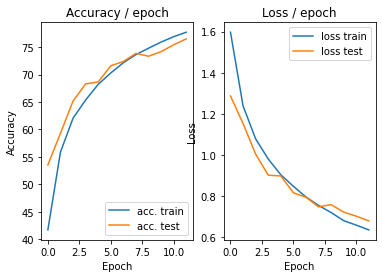

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.224s (0.224s)	Loss 0.6706 (0.6706)	Prec@1  78.9 ( 78.9)	Prec@5  97.7 ( 97.7)


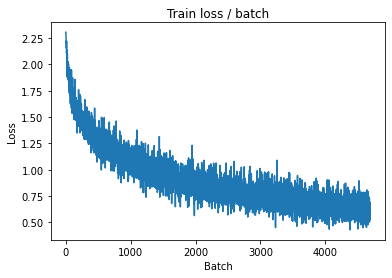

[TRAIN Batch 200/391]	Time 0.030s (0.055s)	Loss 0.4224 (0.6143)	Prec@1  85.9 ( 78.6)	Prec@5  99.2 ( 98.9)


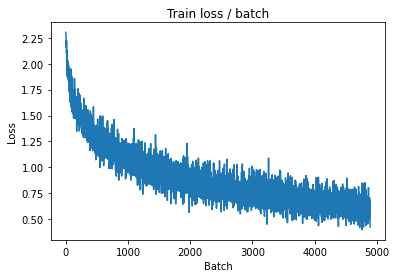


===============> Total time 21s	Avg loss 0.6127	Avg Prec@1 78.56 %	Avg Prec@5 98.83 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 0.5858 (0.5858)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6681	Avg Prec@1 76.32 %	Avg Prec@5 98.60 %



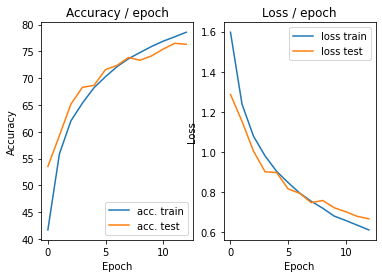

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.230s (0.230s)	Loss 0.5508 (0.5508)	Prec@1  77.3 ( 77.3)	Prec@5 100.0 (100.0)


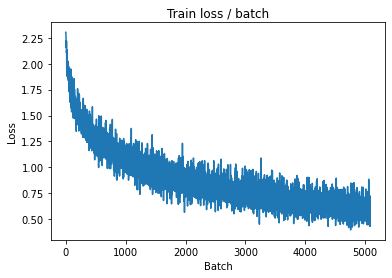

[TRAIN Batch 200/391]	Time 0.075s (0.055s)	Loss 0.7270 (0.5934)	Prec@1  79.7 ( 79.2)	Prec@5  97.7 ( 99.0)


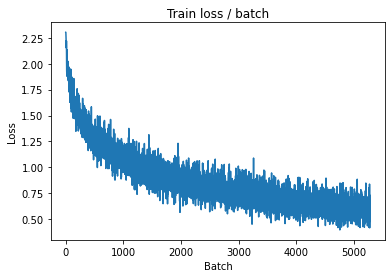


===============> Total time 21s	Avg loss 0.5922	Avg Prec@1 79.29 %	Avg Prec@5 98.99 %

[EVAL Batch 000/079]	Time 0.187s (0.187s)	Loss 0.6420 (0.6420)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6564	Avg Prec@1 77.17 %	Avg Prec@5 98.63 %



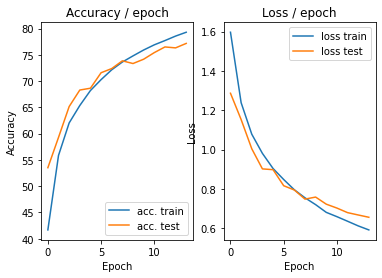

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.236s (0.236s)	Loss 0.6043 (0.6043)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


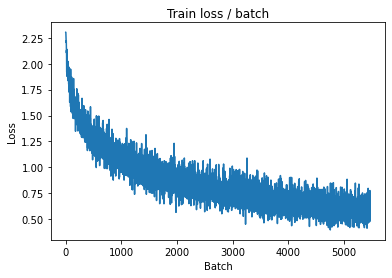

[TRAIN Batch 200/391]	Time 0.023s (0.056s)	Loss 0.6490 (0.5736)	Prec@1  78.9 ( 79.8)	Prec@5  99.2 ( 99.0)


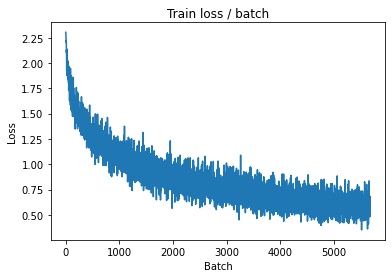


===============> Total time 21s	Avg loss 0.5724	Avg Prec@1 80.00 %	Avg Prec@5 99.00 %

[EVAL Batch 000/079]	Time 0.194s (0.194s)	Loss 0.6487 (0.6487)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6482	Avg Prec@1 77.54 %	Avg Prec@5 98.57 %



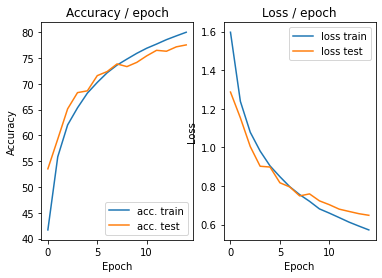

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.245s (0.245s)	Loss 0.4934 (0.4934)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)


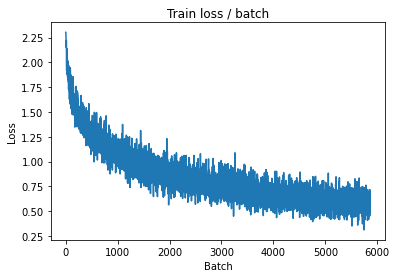

[TRAIN Batch 200/391]	Time 0.087s (0.056s)	Loss 0.6677 (0.5571)	Prec@1  78.9 ( 80.5)	Prec@5  99.2 ( 99.2)


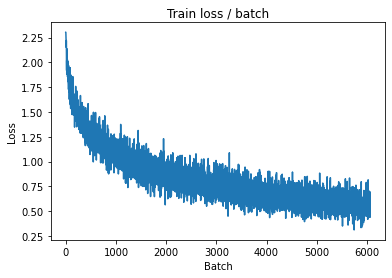


===============> Total time 21s	Avg loss 0.5546	Avg Prec@1 80.62 %	Avg Prec@5 99.10 %

[EVAL Batch 000/079]	Time 0.194s (0.194s)	Loss 0.6119 (0.6119)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6538	Avg Prec@1 77.51 %	Avg Prec@5 98.68 %



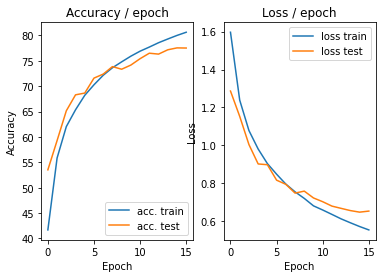

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.232s (0.232s)	Loss 0.6267 (0.6267)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)


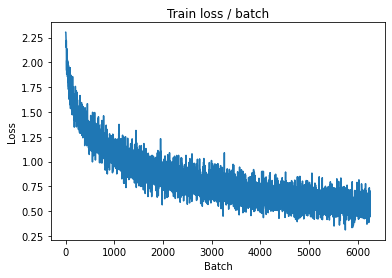

[TRAIN Batch 200/391]	Time 0.020s (0.055s)	Loss 0.6071 (0.5456)	Prec@1  77.3 ( 80.7)	Prec@5  97.7 ( 99.1)


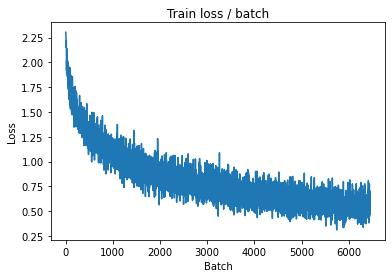


===============> Total time 21s	Avg loss 0.5381	Avg Prec@1 81.17 %	Avg Prec@5 99.10 %

[EVAL Batch 000/079]	Time 0.195s (0.195s)	Loss 0.6326 (0.6326)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6434	Avg Prec@1 77.84 %	Avg Prec@5 98.77 %



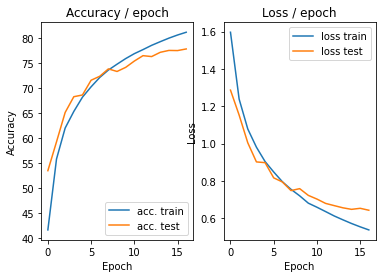

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.263s (0.263s)	Loss 0.6022 (0.6022)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)


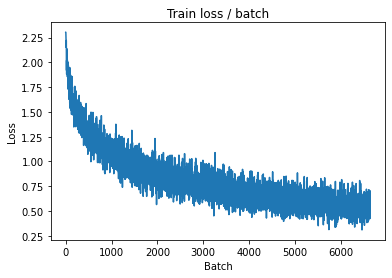

[TRAIN Batch 200/391]	Time 0.023s (0.055s)	Loss 0.4996 (0.5180)	Prec@1  84.4 ( 81.9)	Prec@5 100.0 ( 99.2)


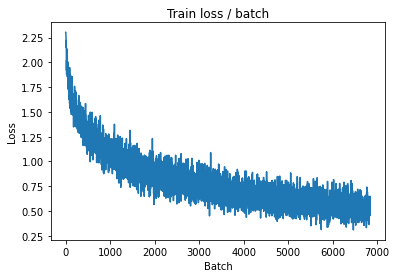


===============> Total time 21s	Avg loss 0.5243	Avg Prec@1 81.74 %	Avg Prec@5 99.16 %

[EVAL Batch 000/079]	Time 0.173s (0.173s)	Loss 0.5663 (0.5663)	Prec@1  81.2 ( 81.2)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 0.6147	Avg Prec@1 79.16 %	Avg Prec@5 98.77 %



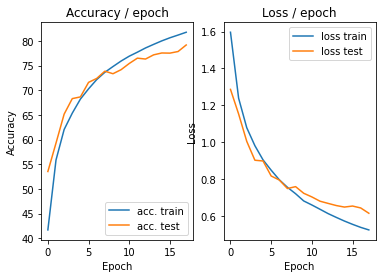

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.225s (0.225s)	Loss 0.4657 (0.4657)	Prec@1  80.5 ( 80.5)	Prec@5 100.0 (100.0)


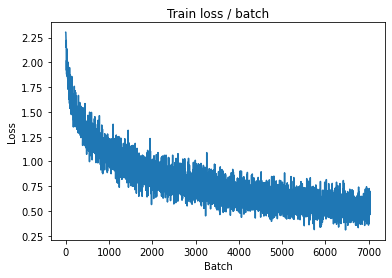

[TRAIN Batch 200/391]	Time 0.033s (0.056s)	Loss 0.5096 (0.5081)	Prec@1  84.4 ( 82.4)	Prec@5  98.4 ( 99.3)


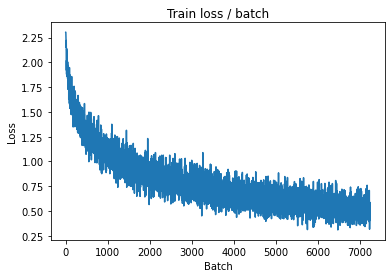


===============> Total time 21s	Avg loss 0.5122	Avg Prec@1 82.16 %	Avg Prec@5 99.25 %

[EVAL Batch 000/079]	Time 0.187s (0.187s)	Loss 0.5550 (0.5550)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6219	Avg Prec@1 78.42 %	Avg Prec@5 98.75 %



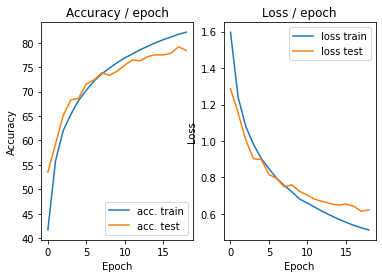

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.230s (0.230s)	Loss 0.4655 (0.4655)	Prec@1  82.8 ( 82.8)	Prec@5 100.0 (100.0)


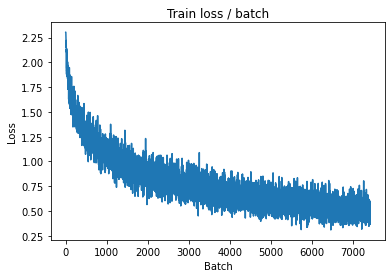

[TRAIN Batch 200/391]	Time 0.076s (0.055s)	Loss 0.5293 (0.4945)	Prec@1  82.8 ( 82.7)	Prec@5  99.2 ( 99.3)


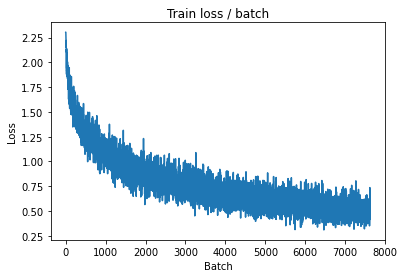


===============> Total time 21s	Avg loss 0.4995	Avg Prec@1 82.51 %	Avg Prec@5 99.27 %

[EVAL Batch 000/079]	Time 0.182s (0.182s)	Loss 0.5561 (0.5561)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6094	Avg Prec@1 78.78 %	Avg Prec@5 98.85 %



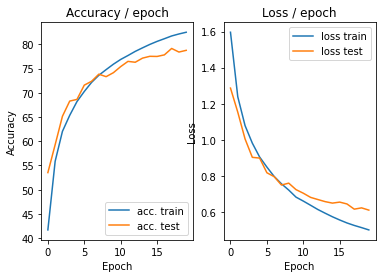

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.246s (0.246s)	Loss 0.3788 (0.3788)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


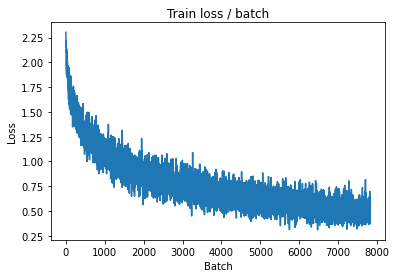

[TRAIN Batch 200/391]	Time 0.074s (0.056s)	Loss 0.4898 (0.4820)	Prec@1  82.0 ( 83.2)	Prec@5  98.4 ( 99.3)


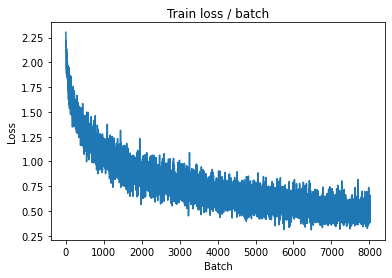


===============> Total time 21s	Avg loss 0.4851	Avg Prec@1 83.02 %	Avg Prec@5 99.32 %

[EVAL Batch 000/079]	Time 0.190s (0.190s)	Loss 0.6098 (0.6098)	Prec@1  81.2 ( 81.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6204	Avg Prec@1 78.40 %	Avg Prec@5 98.67 %



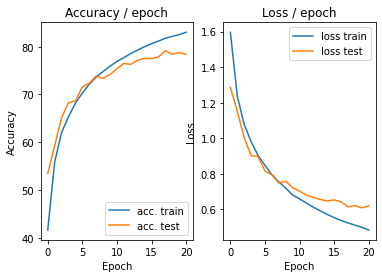

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 0.3922 (0.3922)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


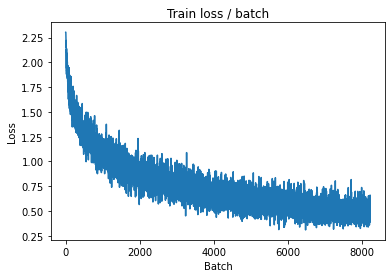

[TRAIN Batch 200/391]	Time 0.030s (0.055s)	Loss 0.4301 (0.4753)	Prec@1  85.2 ( 83.5)	Prec@5 100.0 ( 99.4)


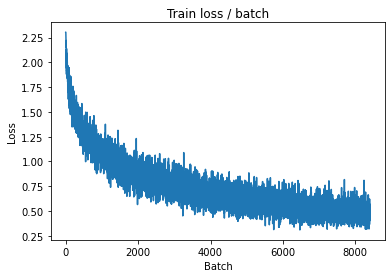


===============> Total time 21s	Avg loss 0.4746	Avg Prec@1 83.44 %	Avg Prec@5 99.35 %

[EVAL Batch 000/079]	Time 0.194s (0.194s)	Loss 0.5717 (0.5717)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6115	Avg Prec@1 78.65 %	Avg Prec@5 98.71 %



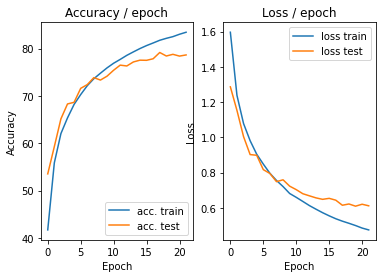

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.229s (0.229s)	Loss 0.3740 (0.3740)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


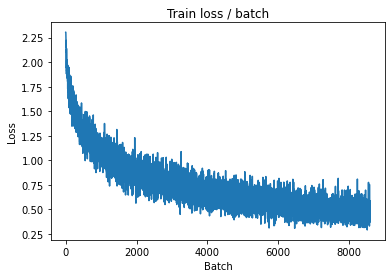

[TRAIN Batch 200/391]	Time 0.027s (0.055s)	Loss 0.5526 (0.4561)	Prec@1  78.9 ( 84.0)	Prec@5  98.4 ( 99.4)


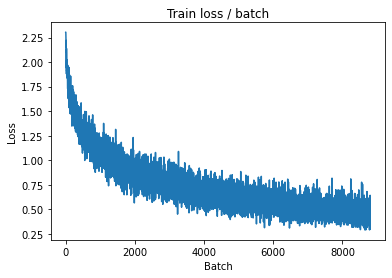


===============> Total time 21s	Avg loss 0.4610	Avg Prec@1 83.82 %	Avg Prec@5 99.39 %

[EVAL Batch 000/079]	Time 0.192s (0.192s)	Loss 0.5413 (0.5413)	Prec@1  81.2 ( 81.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5987	Avg Prec@1 79.51 %	Avg Prec@5 98.72 %



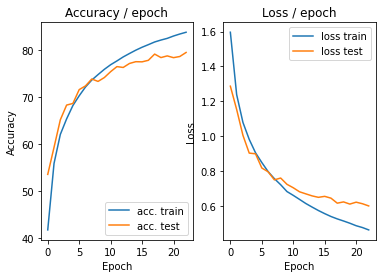

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.233s (0.233s)	Loss 0.5335 (0.5335)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)


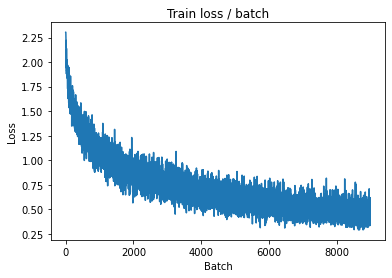

[TRAIN Batch 200/391]	Time 0.088s (0.055s)	Loss 0.4934 (0.4510)	Prec@1  82.8 ( 84.0)	Prec@5  98.4 ( 99.5)


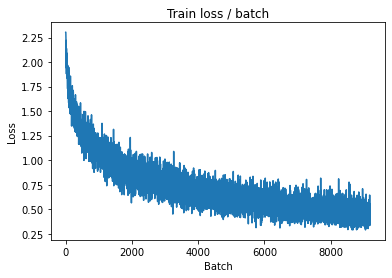


===============> Total time 21s	Avg loss 0.4516	Avg Prec@1 84.05 %	Avg Prec@5 99.43 %

[EVAL Batch 000/079]	Time 0.183s (0.183s)	Loss 0.5401 (0.5401)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6036	Avg Prec@1 79.01 %	Avg Prec@5 98.82 %



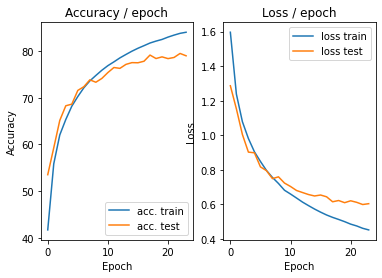

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.248s (0.248s)	Loss 0.3645 (0.3645)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


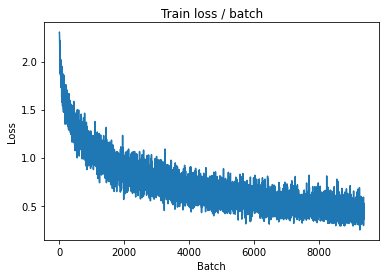

[TRAIN Batch 200/391]	Time 0.026s (0.054s)	Loss 0.4995 (0.4409)	Prec@1  83.6 ( 84.6)	Prec@5  99.2 ( 99.4)


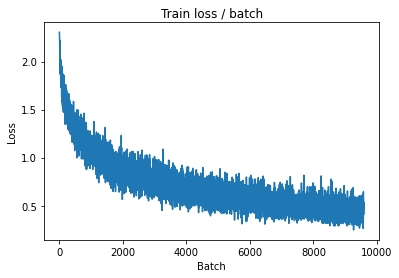


===============> Total time 21s	Avg loss 0.4415	Avg Prec@1 84.64 %	Avg Prec@5 99.43 %

[EVAL Batch 000/079]	Time 0.202s (0.202s)	Loss 0.5668 (0.5668)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5932	Avg Prec@1 79.36 %	Avg Prec@5 98.80 %



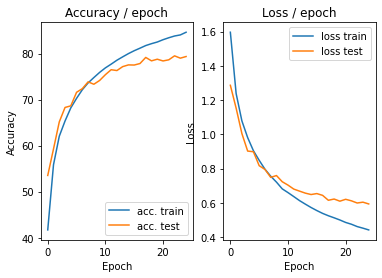

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.238s (0.238s)	Loss 0.3973 (0.3973)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


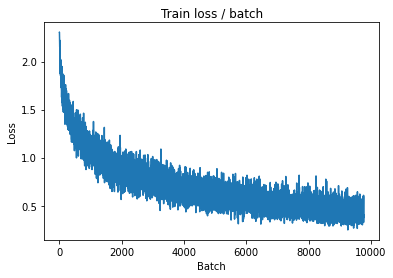

[TRAIN Batch 200/391]	Time 0.076s (0.055s)	Loss 0.3930 (0.4306)	Prec@1  83.6 ( 84.7)	Prec@5  98.4 ( 99.5)


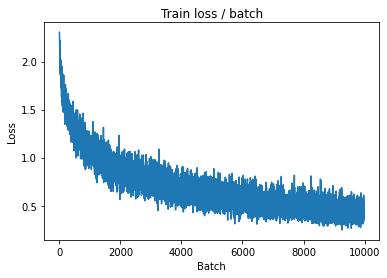


===============> Total time 21s	Avg loss 0.4347	Avg Prec@1 84.75 %	Avg Prec@5 99.48 %

[EVAL Batch 000/079]	Time 0.180s (0.180s)	Loss 0.5368 (0.5368)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5943	Avg Prec@1 79.24 %	Avg Prec@5 98.78 %



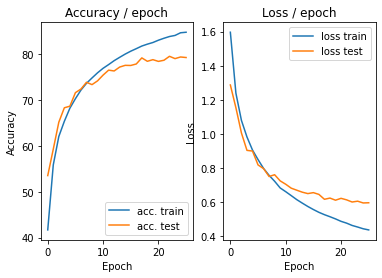

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.240s (0.240s)	Loss 0.3378 (0.3378)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


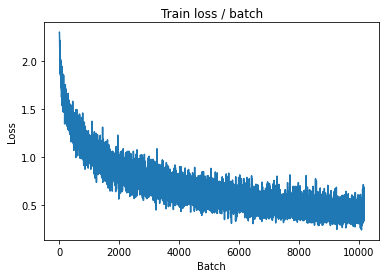

[TRAIN Batch 200/391]	Time 0.020s (0.055s)	Loss 0.4677 (0.4173)	Prec@1  84.4 ( 85.4)	Prec@5 100.0 ( 99.5)


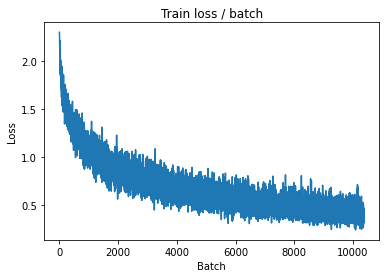


===============> Total time 21s	Avg loss 0.4236	Avg Prec@1 85.22 %	Avg Prec@5 99.50 %

[EVAL Batch 000/079]	Time 0.203s (0.203s)	Loss 0.5644 (0.5644)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5959	Avg Prec@1 79.48 %	Avg Prec@5 98.89 %



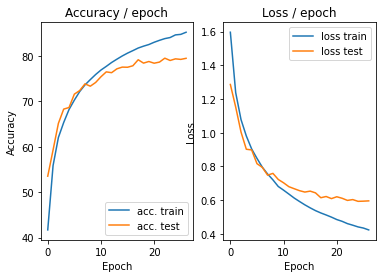

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.244s (0.244s)	Loss 0.5356 (0.5356)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)


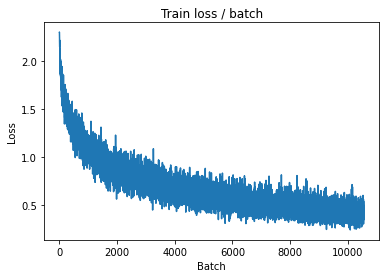

[TRAIN Batch 200/391]	Time 0.095s (0.055s)	Loss 0.3662 (0.4225)	Prec@1  86.7 ( 85.4)	Prec@5 100.0 ( 99.5)


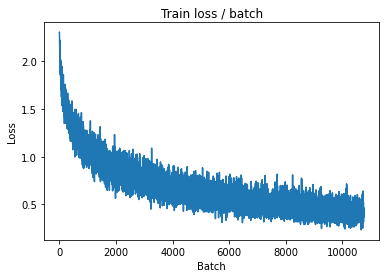


===============> Total time 21s	Avg loss 0.4167	Avg Prec@1 85.56 %	Avg Prec@5 99.52 %

[EVAL Batch 000/079]	Time 0.185s (0.185s)	Loss 0.5571 (0.5571)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5872	Avg Prec@1 80.28 %	Avg Prec@5 98.82 %



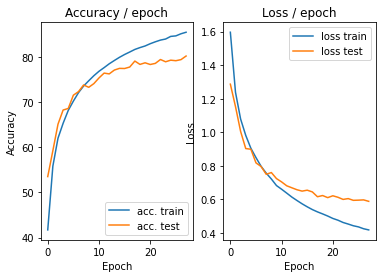

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.258s (0.258s)	Loss 0.4192 (0.4192)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)


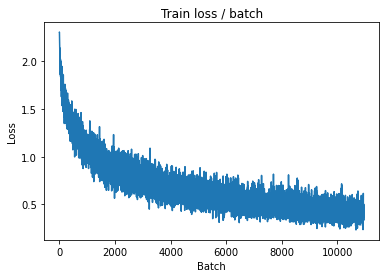

[TRAIN Batch 200/391]	Time 0.069s (0.055s)	Loss 0.4889 (0.4083)	Prec@1  82.8 ( 85.8)	Prec@5  99.2 ( 99.5)


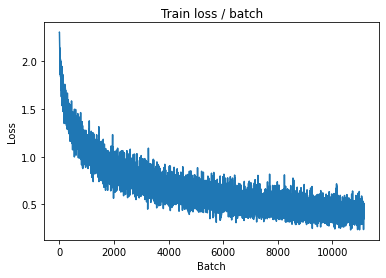


===============> Total time 21s	Avg loss 0.4084	Avg Prec@1 85.84 %	Avg Prec@5 99.55 %

[EVAL Batch 000/079]	Time 0.199s (0.199s)	Loss 0.5779 (0.5779)	Prec@1  81.2 ( 81.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5900	Avg Prec@1 80.03 %	Avg Prec@5 98.86 %



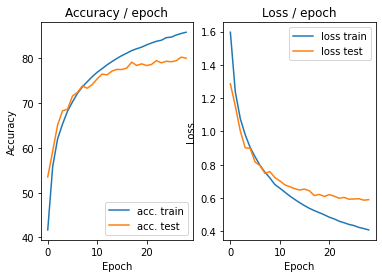

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.245s (0.245s)	Loss 0.4032 (0.4032)	Prec@1  85.2 ( 85.2)	Prec@5 100.0 (100.0)


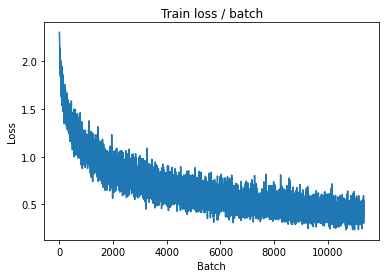

[TRAIN Batch 200/391]	Time 0.091s (0.055s)	Loss 0.4748 (0.3992)	Prec@1  84.4 ( 86.3)	Prec@5  98.4 ( 99.5)


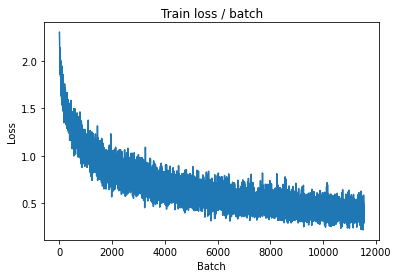


===============> Total time 21s	Avg loss 0.4010	Avg Prec@1 86.22 %	Avg Prec@5 99.53 %

[EVAL Batch 000/079]	Time 0.194s (0.194s)	Loss 0.5571 (0.5571)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5864	Avg Prec@1 80.08 %	Avg Prec@5 98.92 %



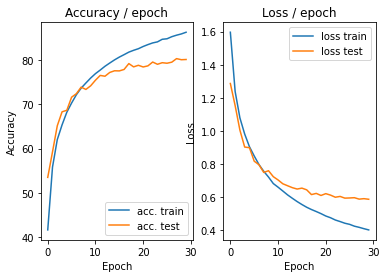

=== EPOCH 31 =====

[TRAIN Batch 000/391]	Time 0.234s (0.234s)	Loss 0.4487 (0.4487)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)


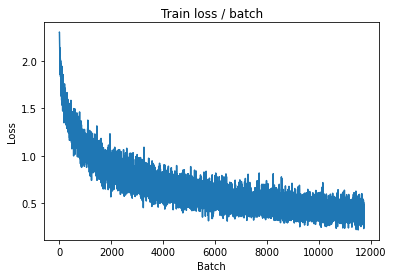

[TRAIN Batch 200/391]	Time 0.055s (0.055s)	Loss 0.4381 (0.3937)	Prec@1  85.9 ( 86.2)	Prec@5  98.4 ( 99.6)


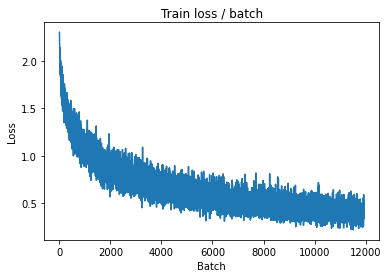


===============> Total time 21s	Avg loss 0.3943	Avg Prec@1 86.20 %	Avg Prec@5 99.56 %

[EVAL Batch 000/079]	Time 0.215s (0.215s)	Loss 0.6024 (0.6024)	Prec@1  78.1 ( 78.1)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5959	Avg Prec@1 79.47 %	Avg Prec@5 98.89 %



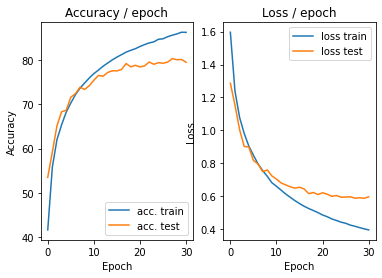

=== EPOCH 32 =====

[TRAIN Batch 000/391]	Time 0.247s (0.247s)	Loss 0.2723 (0.2723)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


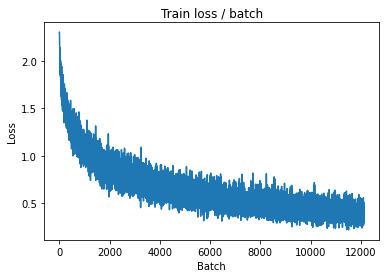

[TRAIN Batch 200/391]	Time 0.020s (0.055s)	Loss 0.4616 (0.3936)	Prec@1  85.9 ( 86.3)	Prec@5  99.2 ( 99.6)


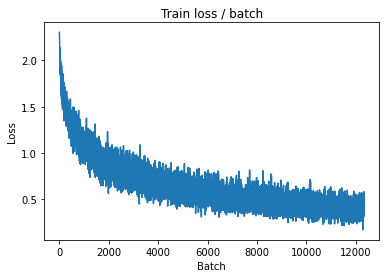


===============> Total time 21s	Avg loss 0.3906	Avg Prec@1 86.43 %	Avg Prec@5 99.58 %

[EVAL Batch 000/079]	Time 0.213s (0.213s)	Loss 0.5130 (0.5130)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5813	Avg Prec@1 80.23 %	Avg Prec@5 98.85 %



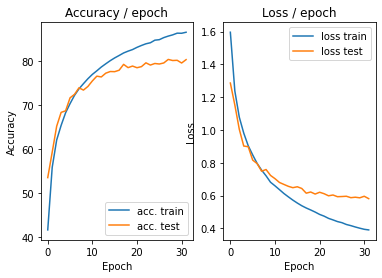

=== EPOCH 33 =====

[TRAIN Batch 000/391]	Time 0.236s (0.236s)	Loss 0.3351 (0.3351)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


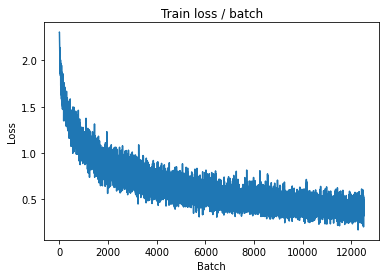

[TRAIN Batch 200/391]	Time 0.021s (0.055s)	Loss 0.3843 (0.3793)	Prec@1  85.9 ( 86.9)	Prec@5 100.0 ( 99.6)


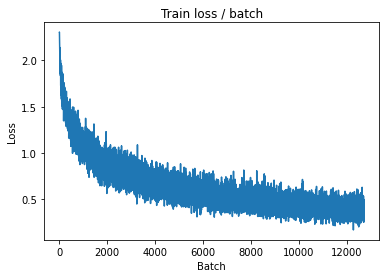


===============> Total time 21s	Avg loss 0.3807	Avg Prec@1 86.77 %	Avg Prec@5 99.62 %

[EVAL Batch 000/079]	Time 0.205s (0.205s)	Loss 0.5318 (0.5318)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5850	Avg Prec@1 80.14 %	Avg Prec@5 98.83 %



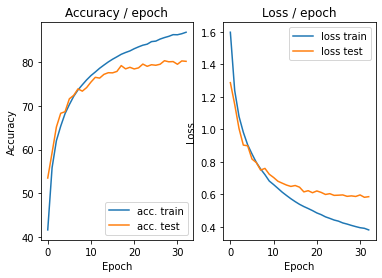

=== EPOCH 34 =====

[TRAIN Batch 000/391]	Time 0.251s (0.251s)	Loss 0.3947 (0.3947)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


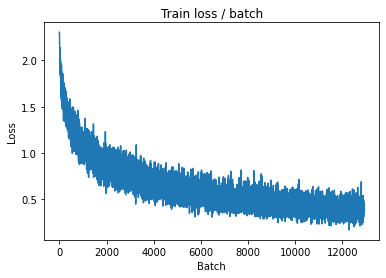

[TRAIN Batch 200/391]	Time 0.073s (0.056s)	Loss 0.4045 (0.3734)	Prec@1  85.9 ( 87.1)	Prec@5 100.0 ( 99.6)


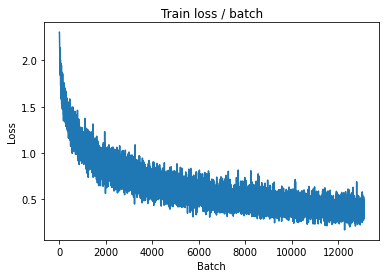


===============> Total time 21s	Avg loss 0.3761	Avg Prec@1 86.94 %	Avg Prec@5 99.63 %

[EVAL Batch 000/079]	Time 0.199s (0.199s)	Loss 0.5423 (0.5423)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5864	Avg Prec@1 80.03 %	Avg Prec@5 98.90 %



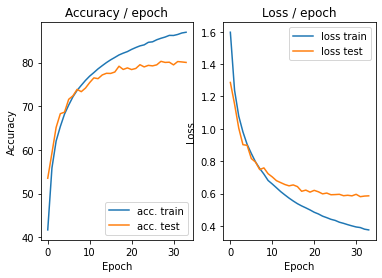

=== EPOCH 35 =====

[TRAIN Batch 000/391]	Time 0.264s (0.264s)	Loss 0.4468 (0.4468)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


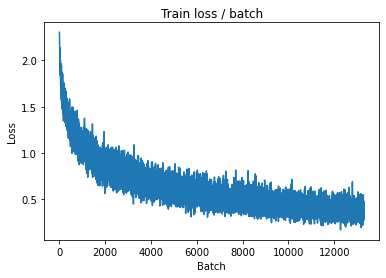

[TRAIN Batch 200/391]	Time 0.055s (0.055s)	Loss 0.3136 (0.3743)	Prec@1  91.4 ( 87.0)	Prec@5 100.0 ( 99.6)


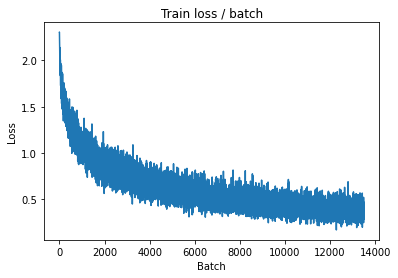


===============> Total time 21s	Avg loss 0.3721	Avg Prec@1 87.07 %	Avg Prec@5 99.62 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 0.5342 (0.5342)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5804	Avg Prec@1 80.20 %	Avg Prec@5 98.90 %



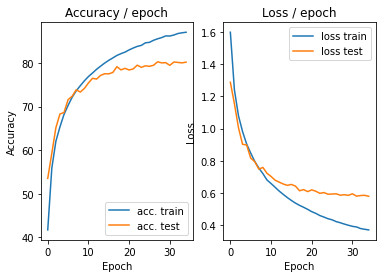

=== EPOCH 36 =====

[TRAIN Batch 000/391]	Time 0.261s (0.261s)	Loss 0.4475 (0.4475)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


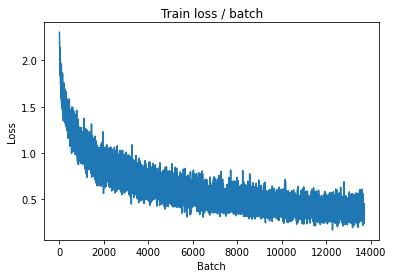

[TRAIN Batch 200/391]	Time 0.024s (0.056s)	Loss 0.4288 (0.3599)	Prec@1  82.8 ( 87.4)	Prec@5 100.0 ( 99.6)


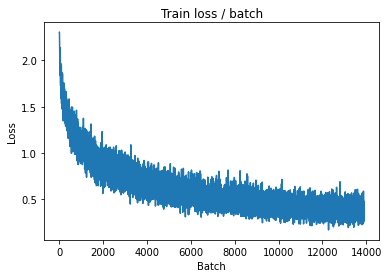


===============> Total time 21s	Avg loss 0.3636	Avg Prec@1 87.34 %	Avg Prec@5 99.64 %

[EVAL Batch 000/079]	Time 0.204s (0.204s)	Loss 0.5565 (0.5565)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5824	Avg Prec@1 80.64 %	Avg Prec@5 98.93 %



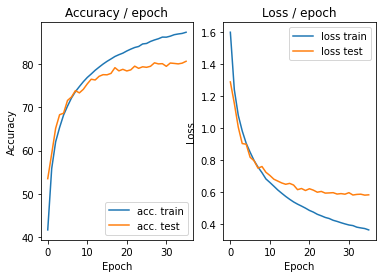

=== EPOCH 37 =====

[TRAIN Batch 000/391]	Time 0.244s (0.244s)	Loss 0.3086 (0.3086)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


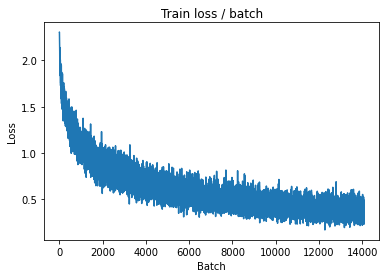

[TRAIN Batch 200/391]	Time 0.019s (0.056s)	Loss 0.2558 (0.3516)	Prec@1  91.4 ( 87.6)	Prec@5 100.0 ( 99.7)


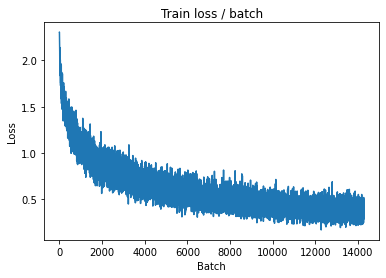


===============> Total time 21s	Avg loss 0.3608	Avg Prec@1 87.36 %	Avg Prec@5 99.65 %

[EVAL Batch 000/079]	Time 0.203s (0.203s)	Loss 0.5359 (0.5359)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5810	Avg Prec@1 80.56 %	Avg Prec@5 98.88 %



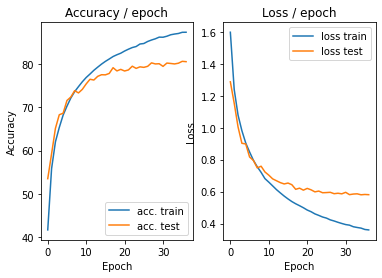

=== EPOCH 38 =====

[TRAIN Batch 000/391]	Time 0.261s (0.261s)	Loss 0.3253 (0.3253)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


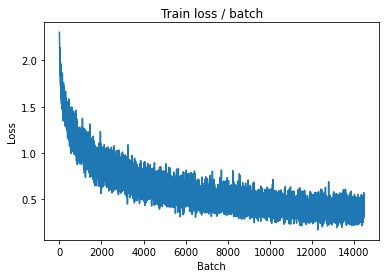

[TRAIN Batch 200/391]	Time 0.024s (0.056s)	Loss 0.3309 (0.3521)	Prec@1  88.3 ( 87.7)	Prec@5 100.0 ( 99.7)


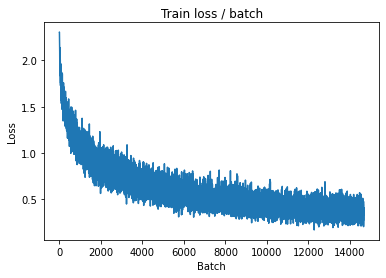


===============> Total time 21s	Avg loss 0.3542	Avg Prec@1 87.66 %	Avg Prec@5 99.66 %

[EVAL Batch 000/079]	Time 0.184s (0.184s)	Loss 0.5785 (0.5785)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5819	Avg Prec@1 80.53 %	Avg Prec@5 98.93 %



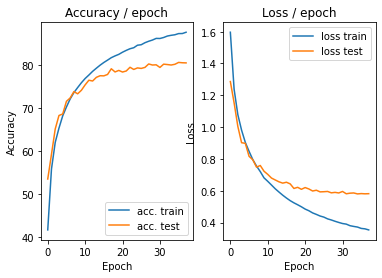

=== EPOCH 39 =====

[TRAIN Batch 000/391]	Time 0.238s (0.238s)	Loss 0.4126 (0.4126)	Prec@1  88.3 ( 88.3)	Prec@5  99.2 ( 99.2)


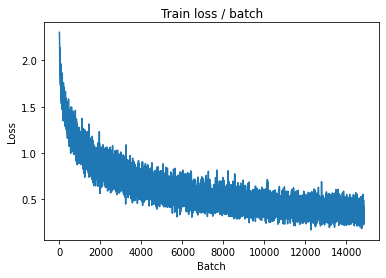

[TRAIN Batch 200/391]	Time 0.065s (0.055s)	Loss 0.3024 (0.3542)	Prec@1  89.1 ( 87.9)	Prec@5 100.0 ( 99.7)


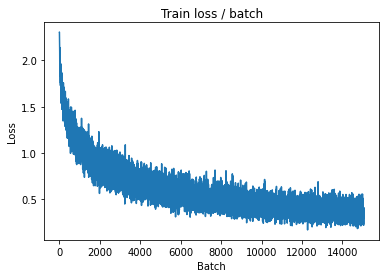


===============> Total time 21s	Avg loss 0.3499	Avg Prec@1 87.93 %	Avg Prec@5 99.68 %

[EVAL Batch 000/079]	Time 0.202s (0.202s)	Loss 0.5792 (0.5792)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5840	Avg Prec@1 80.58 %	Avg Prec@5 98.89 %



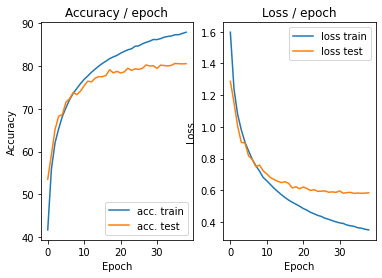

=== EPOCH 40 =====

[TRAIN Batch 000/391]	Time 0.246s (0.246s)	Loss 0.2710 (0.2710)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


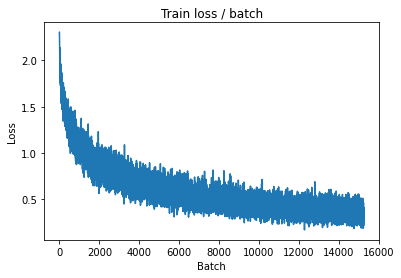

[TRAIN Batch 200/391]	Time 0.019s (0.055s)	Loss 0.3573 (0.3468)	Prec@1  88.3 ( 88.2)	Prec@5 100.0 ( 99.6)


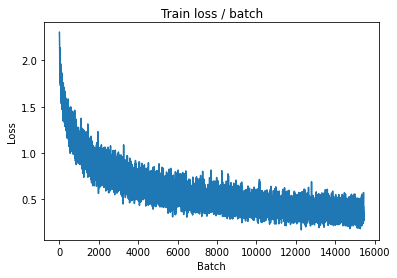


===============> Total time 21s	Avg loss 0.3425	Avg Prec@1 88.24 %	Avg Prec@5 99.67 %

[EVAL Batch 000/079]	Time 0.212s (0.212s)	Loss 0.5563 (0.5563)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5826	Avg Prec@1 80.41 %	Avg Prec@5 98.98 %



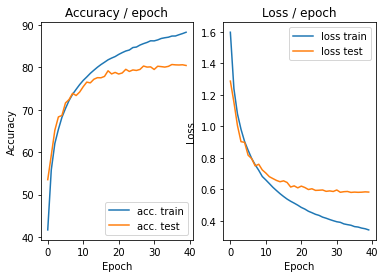

=== EPOCH 41 =====

[TRAIN Batch 000/391]	Time 0.242s (0.242s)	Loss 0.2767 (0.2767)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)


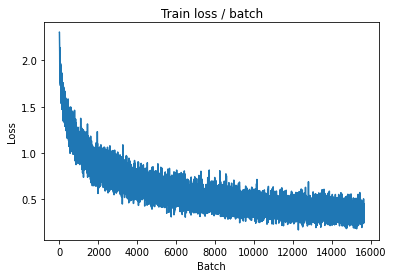

[TRAIN Batch 200/391]	Time 0.078s (0.056s)	Loss 0.2922 (0.3371)	Prec@1  89.1 ( 88.3)	Prec@5 100.0 ( 99.7)


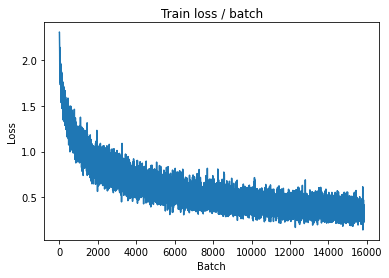


===============> Total time 21s	Avg loss 0.3388	Avg Prec@1 88.16 %	Avg Prec@5 99.72 %

[EVAL Batch 000/079]	Time 0.213s (0.213s)	Loss 0.5697 (0.5697)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5833	Avg Prec@1 80.37 %	Avg Prec@5 98.96 %



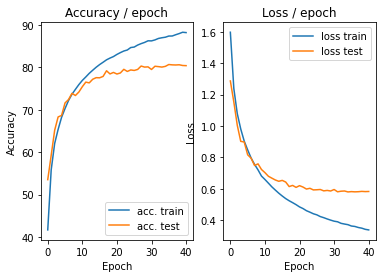

=== EPOCH 42 =====

[TRAIN Batch 000/391]	Time 0.250s (0.250s)	Loss 0.2770 (0.2770)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)


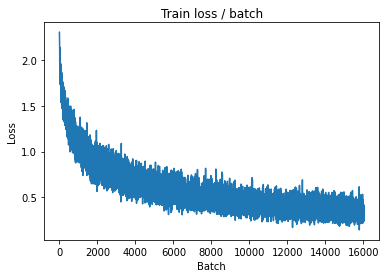

[TRAIN Batch 200/391]	Time 0.097s (0.055s)	Loss 0.3702 (0.3351)	Prec@1  87.5 ( 88.5)	Prec@5  99.2 ( 99.7)


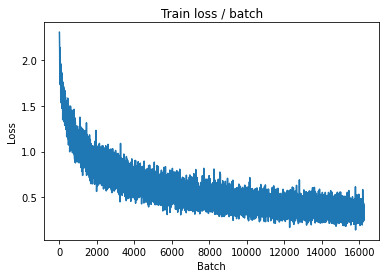


===============> Total time 21s	Avg loss 0.3374	Avg Prec@1 88.27 %	Avg Prec@5 99.70 %

[EVAL Batch 000/079]	Time 0.196s (0.196s)	Loss 0.5706 (0.5706)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5904	Avg Prec@1 80.45 %	Avg Prec@5 98.90 %



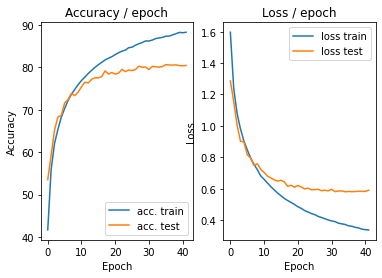

=== EPOCH 43 =====

[TRAIN Batch 000/391]	Time 0.256s (0.256s)	Loss 0.4008 (0.4008)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


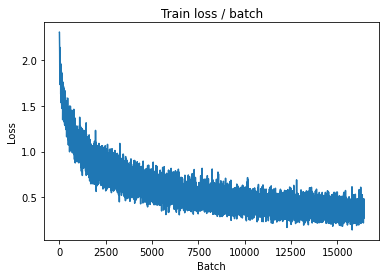

[TRAIN Batch 200/391]	Time 0.078s (0.055s)	Loss 0.3124 (0.3346)	Prec@1  93.0 ( 88.3)	Prec@5  99.2 ( 99.8)


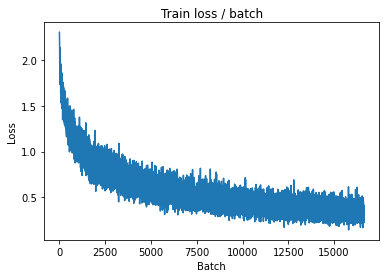


===============> Total time 21s	Avg loss 0.3340	Avg Prec@1 88.28 %	Avg Prec@5 99.75 %

[EVAL Batch 000/079]	Time 0.204s (0.204s)	Loss 0.5478 (0.5478)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5821	Avg Prec@1 80.48 %	Avg Prec@5 98.90 %



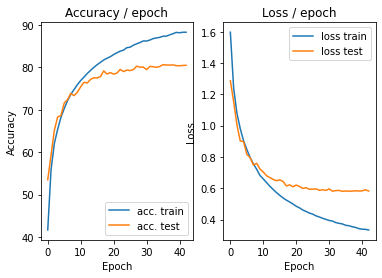

=== EPOCH 44 =====

[TRAIN Batch 000/391]	Time 0.246s (0.246s)	Loss 0.3586 (0.3586)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


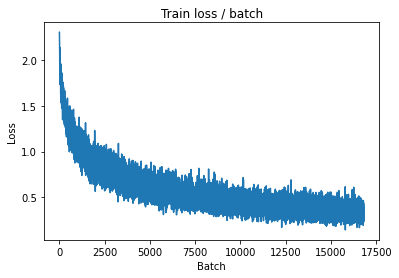

[TRAIN Batch 200/391]	Time 0.027s (0.055s)	Loss 0.2898 (0.3349)	Prec@1  89.1 ( 88.5)	Prec@5 100.0 ( 99.7)


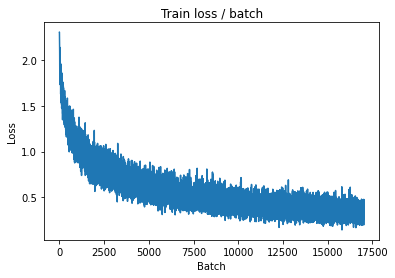


===============> Total time 21s	Avg loss 0.3298	Avg Prec@1 88.62 %	Avg Prec@5 99.71 %

[EVAL Batch 000/079]	Time 0.189s (0.189s)	Loss 0.5750 (0.5750)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5851	Avg Prec@1 80.46 %	Avg Prec@5 98.97 %



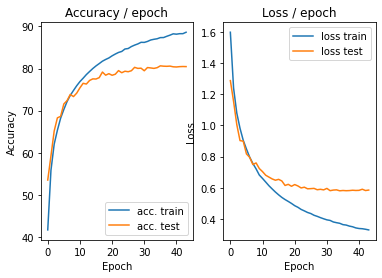

=== EPOCH 45 =====

[TRAIN Batch 000/391]	Time 0.256s (0.256s)	Loss 0.2578 (0.2578)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


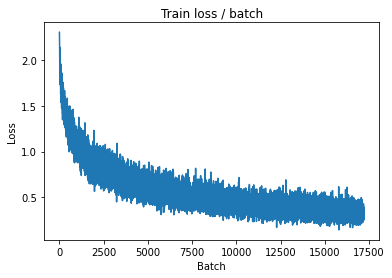

[TRAIN Batch 200/391]	Time 0.032s (0.055s)	Loss 0.2935 (0.3278)	Prec@1  89.1 ( 88.4)	Prec@5 100.0 ( 99.8)


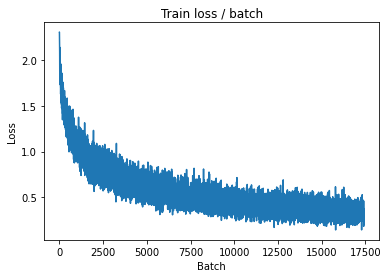


===============> Total time 21s	Avg loss 0.3285	Avg Prec@1 88.54 %	Avg Prec@5 99.76 %

[EVAL Batch 000/079]	Time 0.199s (0.199s)	Loss 0.5479 (0.5479)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5799	Avg Prec@1 80.80 %	Avg Prec@5 98.96 %



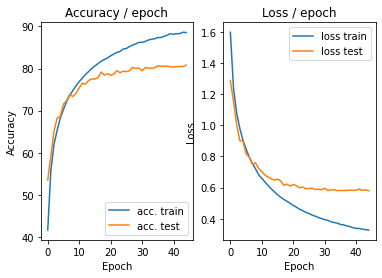

=== EPOCH 46 =====

[TRAIN Batch 000/391]	Time 0.236s (0.236s)	Loss 0.3110 (0.3110)	Prec@1  91.4 ( 91.4)	Prec@5  99.2 ( 99.2)


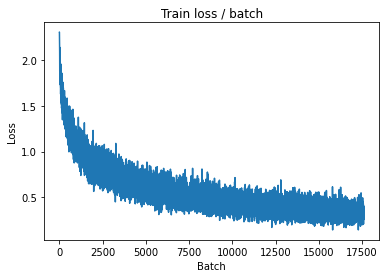

[TRAIN Batch 200/391]	Time 0.032s (0.056s)	Loss 0.2851 (0.3187)	Prec@1  89.1 ( 88.8)	Prec@5 100.0 ( 99.8)


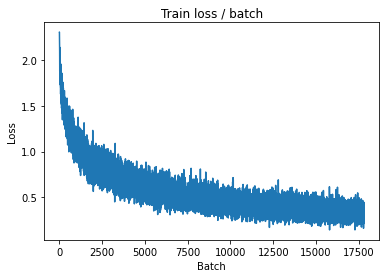


===============> Total time 21s	Avg loss 0.3216	Avg Prec@1 88.75 %	Avg Prec@5 99.75 %

[EVAL Batch 000/079]	Time 0.198s (0.198s)	Loss 0.6093 (0.6093)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5935	Avg Prec@1 80.65 %	Avg Prec@5 98.92 %



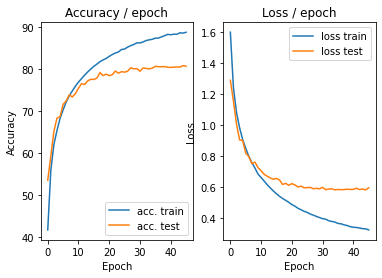

=== EPOCH 47 =====

[TRAIN Batch 000/391]	Time 0.257s (0.257s)	Loss 0.2500 (0.2500)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


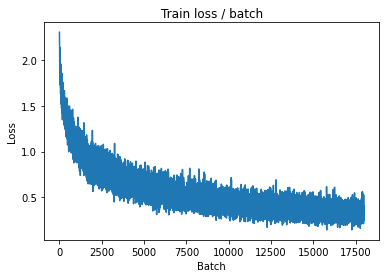

[TRAIN Batch 200/391]	Time 0.060s (0.055s)	Loss 0.4052 (0.3247)	Prec@1  83.6 ( 88.9)	Prec@5  99.2 ( 99.7)


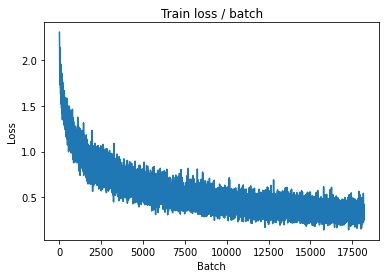


===============> Total time 21s	Avg loss 0.3234	Avg Prec@1 88.97 %	Avg Prec@5 99.75 %

[EVAL Batch 000/079]	Time 0.182s (0.182s)	Loss 0.5640 (0.5640)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5823	Avg Prec@1 80.80 %	Avg Prec@5 98.93 %



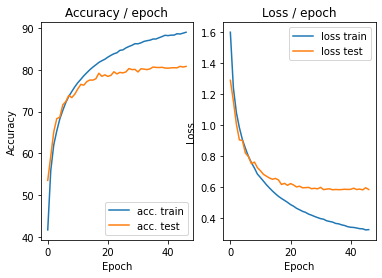

=== EPOCH 48 =====

[TRAIN Batch 000/391]	Time 0.266s (0.266s)	Loss 0.2453 (0.2453)	Prec@1  93.0 ( 93.0)	Prec@5  98.4 ( 98.4)


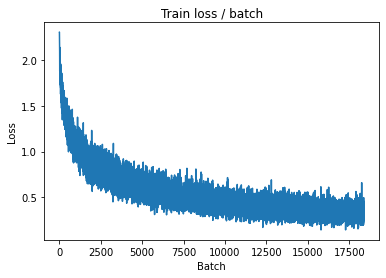

[TRAIN Batch 200/391]	Time 0.093s (0.056s)	Loss 0.3061 (0.3219)	Prec@1  88.3 ( 88.9)	Prec@5 100.0 ( 99.7)


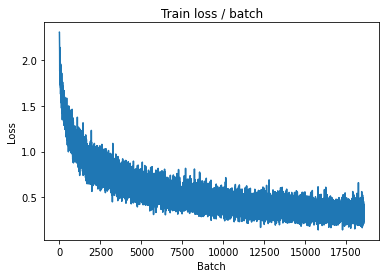


===============> Total time 21s	Avg loss 0.3197	Avg Prec@1 89.02 %	Avg Prec@5 99.74 %

[EVAL Batch 000/079]	Time 0.196s (0.196s)	Loss 0.5929 (0.5929)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5819	Avg Prec@1 80.66 %	Avg Prec@5 99.00 %



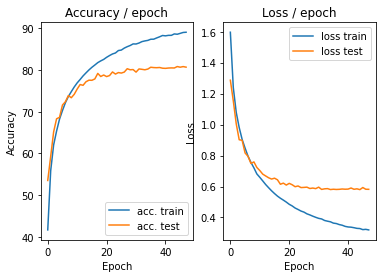

=== EPOCH 49 =====

[TRAIN Batch 000/391]	Time 0.269s (0.269s)	Loss 0.2660 (0.2660)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


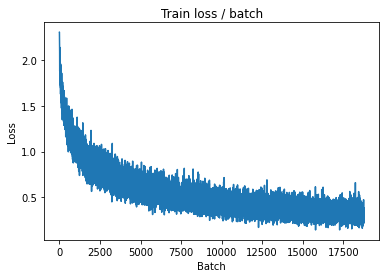

[TRAIN Batch 200/391]	Time 0.031s (0.055s)	Loss 0.3196 (0.3132)	Prec@1  89.1 ( 89.2)	Prec@5 100.0 ( 99.7)


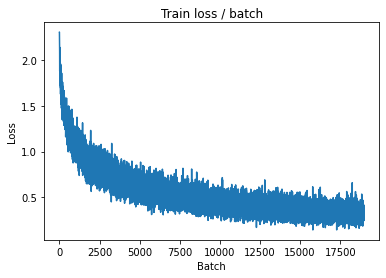


===============> Total time 21s	Avg loss 0.3140	Avg Prec@1 89.20 %	Avg Prec@5 99.75 %

[EVAL Batch 000/079]	Time 0.210s (0.210s)	Loss 0.5965 (0.5965)	Prec@1  81.2 ( 81.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5853	Avg Prec@1 80.74 %	Avg Prec@5 98.91 %



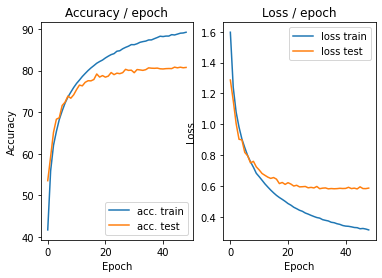

=== EPOCH 50 =====

[TRAIN Batch 000/391]	Time 0.245s (0.245s)	Loss 0.3690 (0.3690)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)


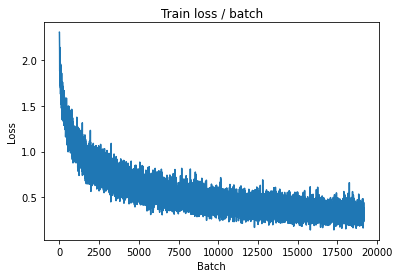

[TRAIN Batch 200/391]	Time 0.020s (0.056s)	Loss 0.4152 (0.3065)	Prec@1  86.7 ( 89.5)	Prec@5  99.2 ( 99.7)


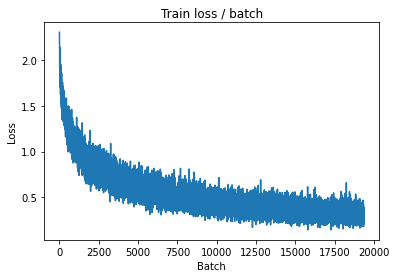


===============> Total time 21s	Avg loss 0.3116	Avg Prec@1 89.31 %	Avg Prec@5 99.73 %

[EVAL Batch 000/079]	Time 0.205s (0.205s)	Loss 0.5612 (0.5612)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5804	Avg Prec@1 80.70 %	Avg Prec@5 98.85 %



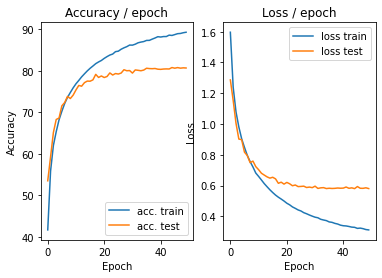

=== EPOCH 51 =====

[TRAIN Batch 000/391]	Time 0.250s (0.250s)	Loss 0.2284 (0.2284)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


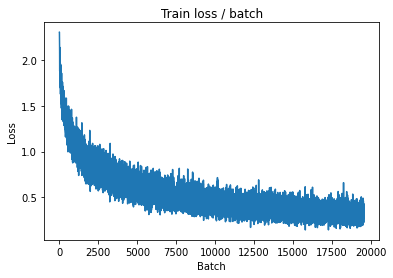

[TRAIN Batch 200/391]	Time 0.058s (0.055s)	Loss 0.2329 (0.3092)	Prec@1  90.6 ( 89.2)	Prec@5 100.0 ( 99.8)


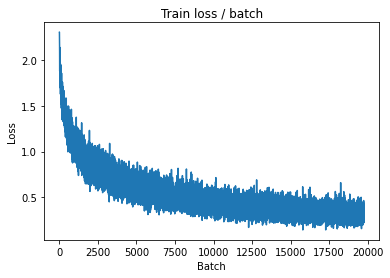


===============> Total time 21s	Avg loss 0.3131	Avg Prec@1 89.19 %	Avg Prec@5 99.74 %

[EVAL Batch 000/079]	Time 0.198s (0.198s)	Loss 0.5570 (0.5570)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5778	Avg Prec@1 80.91 %	Avg Prec@5 98.94 %



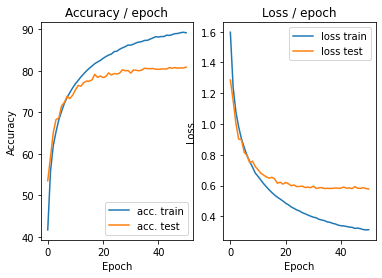

=== EPOCH 52 =====

[TRAIN Batch 000/391]	Time 0.260s (0.260s)	Loss 0.3344 (0.3344)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


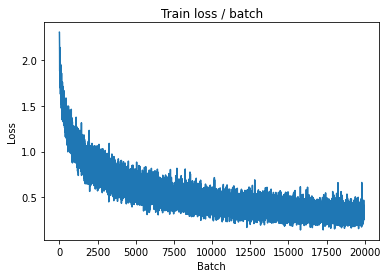

[TRAIN Batch 200/391]	Time 0.037s (0.055s)	Loss 0.2978 (0.3061)	Prec@1  88.3 ( 89.4)	Prec@5 100.0 ( 99.8)


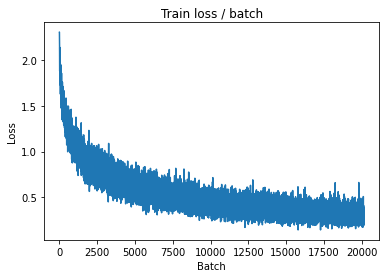


===============> Total time 21s	Avg loss 0.3045	Avg Prec@1 89.49 %	Avg Prec@5 99.76 %

[EVAL Batch 000/079]	Time 0.213s (0.213s)	Loss 0.5948 (0.5948)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5853	Avg Prec@1 80.64 %	Avg Prec@5 98.89 %



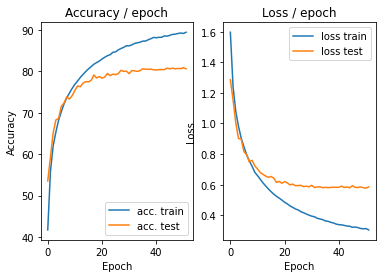

=== EPOCH 53 =====

[TRAIN Batch 000/391]	Time 0.252s (0.252s)	Loss 0.2808 (0.2808)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


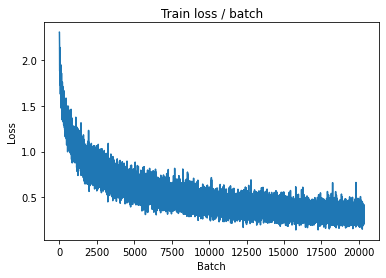

[TRAIN Batch 200/391]	Time 0.019s (0.055s)	Loss 0.3125 (0.3044)	Prec@1  91.4 ( 89.5)	Prec@5  99.2 ( 99.8)


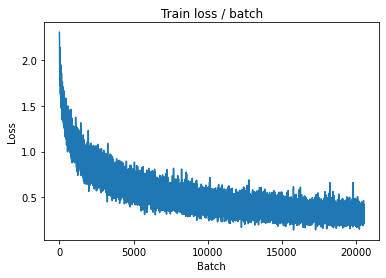


===============> Total time 21s	Avg loss 0.3046	Avg Prec@1 89.45 %	Avg Prec@5 99.77 %

[EVAL Batch 000/079]	Time 0.218s (0.218s)	Loss 0.5636 (0.5636)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5819	Avg Prec@1 80.77 %	Avg Prec@5 98.99 %



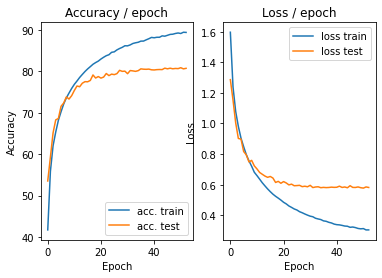

=== EPOCH 54 =====

[TRAIN Batch 000/391]	Time 0.249s (0.249s)	Loss 0.2438 (0.2438)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)


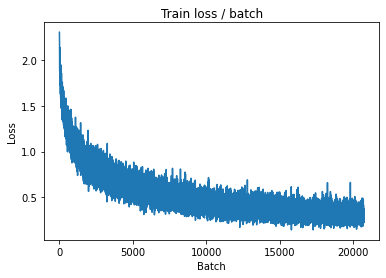

[TRAIN Batch 200/391]	Time 0.030s (0.056s)	Loss 0.3539 (0.3028)	Prec@1  88.3 ( 89.8)	Prec@5 100.0 ( 99.8)


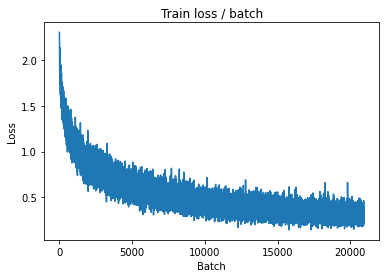


===============> Total time 21s	Avg loss 0.3027	Avg Prec@1 89.75 %	Avg Prec@5 99.76 %

[EVAL Batch 000/079]	Time 0.207s (0.207s)	Loss 0.5966 (0.5966)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5873	Avg Prec@1 80.40 %	Avg Prec@5 98.97 %



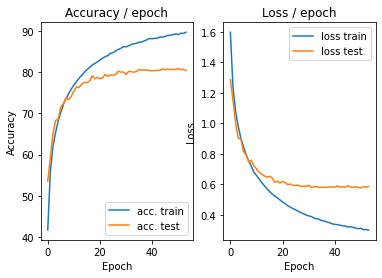

=== EPOCH 55 =====

[TRAIN Batch 000/391]	Time 0.268s (0.268s)	Loss 0.3263 (0.3263)	Prec@1  91.4 ( 91.4)	Prec@5  98.4 ( 98.4)


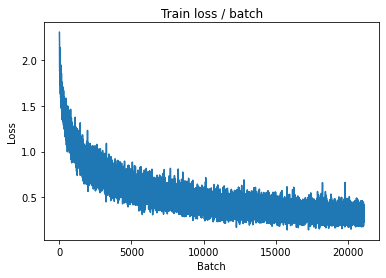

[TRAIN Batch 200/391]	Time 0.057s (0.055s)	Loss 0.2696 (0.2961)	Prec@1  87.5 ( 89.7)	Prec@5 100.0 ( 99.8)


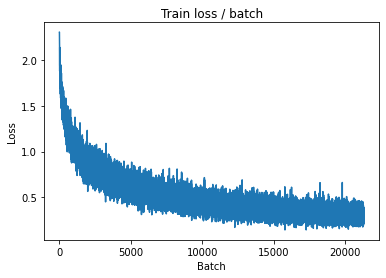


===============> Total time 21s	Avg loss 0.3017	Avg Prec@1 89.56 %	Avg Prec@5 99.75 %

[EVAL Batch 000/079]	Time 0.208s (0.208s)	Loss 0.5831 (0.5831)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5830	Avg Prec@1 80.84 %	Avg Prec@5 99.00 %



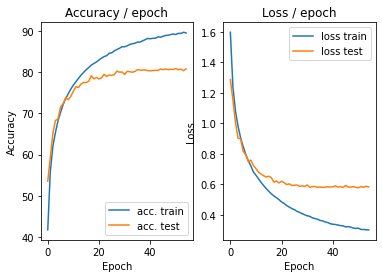

=== EPOCH 56 =====

[TRAIN Batch 000/391]	Time 0.257s (0.257s)	Loss 0.2534 (0.2534)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


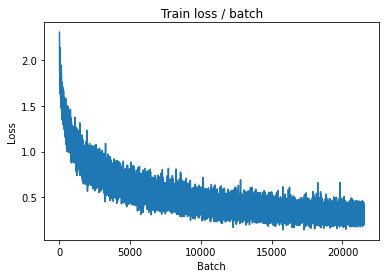

[TRAIN Batch 200/391]	Time 0.090s (0.056s)	Loss 0.2230 (0.2987)	Prec@1  89.1 ( 89.8)	Prec@5  99.2 ( 99.8)


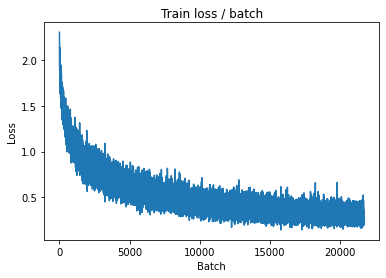


===============> Total time 21s	Avg loss 0.2980	Avg Prec@1 89.78 %	Avg Prec@5 99.79 %

[EVAL Batch 000/079]	Time 0.209s (0.209s)	Loss 0.6027 (0.6027)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5876	Avg Prec@1 80.75 %	Avg Prec@5 98.90 %



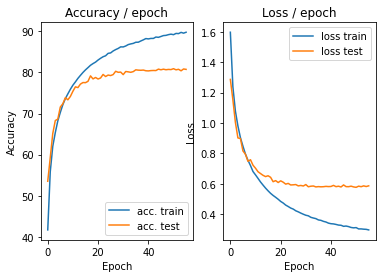

=== EPOCH 57 =====

[TRAIN Batch 000/391]	Time 0.253s (0.253s)	Loss 0.2632 (0.2632)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


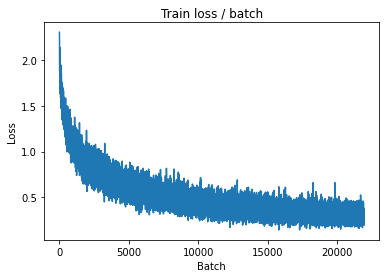

[TRAIN Batch 200/391]	Time 0.026s (0.055s)	Loss 0.3493 (0.2993)	Prec@1  89.1 ( 89.6)	Prec@5 100.0 ( 99.8)


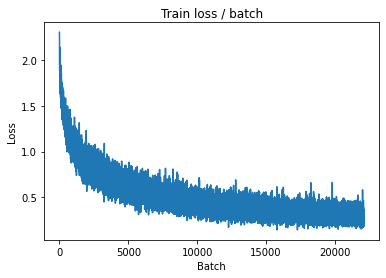


===============> Total time 21s	Avg loss 0.3000	Avg Prec@1 89.61 %	Avg Prec@5 99.80 %

[EVAL Batch 000/079]	Time 0.210s (0.210s)	Loss 0.5621 (0.5621)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5813	Avg Prec@1 80.80 %	Avg Prec@5 98.96 %



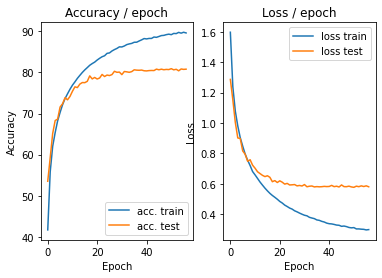

=== EPOCH 58 =====

[TRAIN Batch 000/391]	Time 0.266s (0.266s)	Loss 0.3079 (0.3079)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)


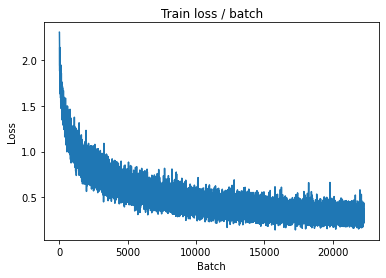

[TRAIN Batch 200/391]	Time 0.021s (0.057s)	Loss 0.2478 (0.2920)	Prec@1  92.2 ( 90.1)	Prec@5  99.2 ( 99.8)


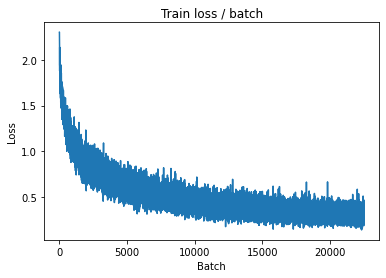


===============> Total time 21s	Avg loss 0.2952	Avg Prec@1 89.84 %	Avg Prec@5 99.77 %

[EVAL Batch 000/079]	Time 0.187s (0.187s)	Loss 0.5858 (0.5858)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5839	Avg Prec@1 80.92 %	Avg Prec@5 99.01 %



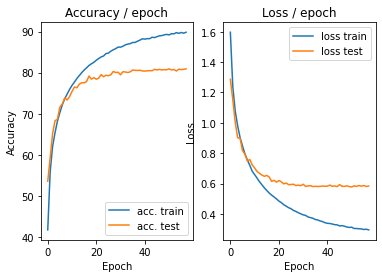

=== EPOCH 59 =====

[TRAIN Batch 000/391]	Time 0.266s (0.266s)	Loss 0.2196 (0.2196)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


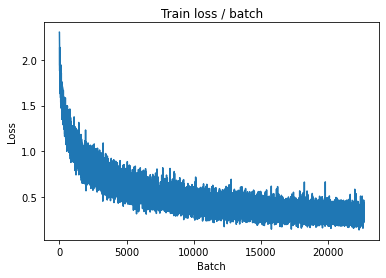

[TRAIN Batch 200/391]	Time 0.048s (0.056s)	Loss 0.2943 (0.2958)	Prec@1  90.6 ( 89.8)	Prec@5 100.0 ( 99.8)


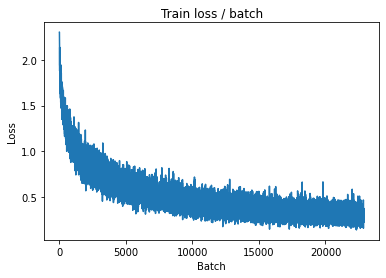


===============> Total time 21s	Avg loss 0.2964	Avg Prec@1 89.75 %	Avg Prec@5 99.79 %

[EVAL Batch 000/079]	Time 0.223s (0.223s)	Loss 0.5779 (0.5779)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5858	Avg Prec@1 80.68 %	Avg Prec@5 98.97 %



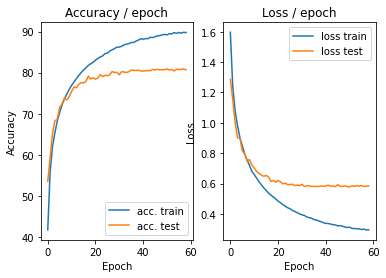

=== EPOCH 60 =====

[TRAIN Batch 000/391]	Time 0.302s (0.302s)	Loss 0.3857 (0.3857)	Prec@1  88.3 ( 88.3)	Prec@5  98.4 ( 98.4)


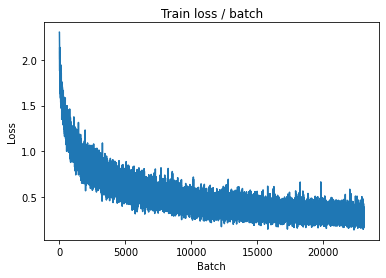

[TRAIN Batch 200/391]	Time 0.019s (0.056s)	Loss 0.2870 (0.2866)	Prec@1  92.2 ( 90.1)	Prec@5 100.0 ( 99.8)


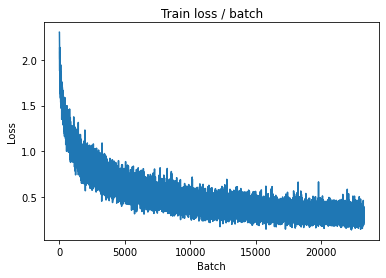


===============> Total time 21s	Avg loss 0.2907	Avg Prec@1 89.91 %	Avg Prec@5 99.79 %

[EVAL Batch 000/079]	Time 0.227s (0.227s)	Loss 0.5870 (0.5870)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.5861	Avg Prec@1 80.79 %	Avg Prec@5 98.92 %



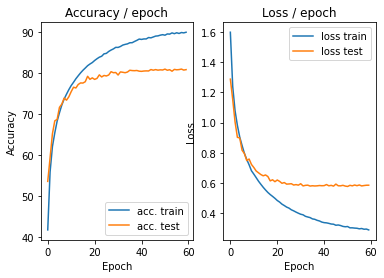

=== EPOCH 61 =====

[TRAIN Batch 000/391]	Time 0.249s (0.249s)	Loss 0.3834 (0.3834)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)


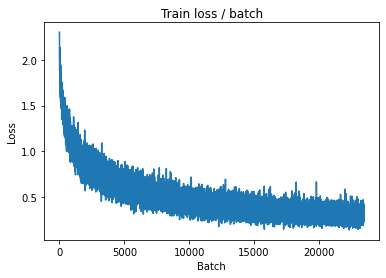

KeyboardInterrupt: ignored

In [ ]:

main(128, 3e-4, cuda=True)